(This file was run successfully on Google Colab)

First we will work on Sign Language MNIST dataset using SparkML

The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).



## **1) sparkML model: (RANDOM FOREST MODEL)**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=0b64cc6411fe7290f52ca065e06e42a67807da6067e4ddbc3b70724a94e02bb1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession, types
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName("SignLanguageClassifier").getOrCreate()

In [4]:
sign_schema = types.StructType([
    types.StructField('label', types.IntegerType()),
    *[types.StructField(f'pixel{i}', types.IntegerType()) for i in range(1,785)]
])

In [5]:
from functools import reduce


data = spark.read.csv(r'/content/sign_mnist_train.csv', header = True, schema = sign_schema)
train, validation = data.randomSplit([0.75, 0.25])

In [6]:
features_data_cols = [f"pixel{i}" for i in range(1, 785)]

In [7]:
features = VectorAssembler(inputCols = features_data_cols, outputCol = 'features')

In [8]:
sign_classifier = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

In [9]:
sign_pipeline = Pipeline(stages =[features, sign_classifier])

In [10]:
sign_model = sign_pipeline.fit(train)

In [11]:
predictions = sign_model.transform(validation)

In [12]:
sign_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol ='prediction', metricName = 'accuracy')

In [13]:
sign_accuracy = sign_evaluator.evaluate(predictions)

In [14]:
print(f"Accuracy: {sign_accuracy}")

Accuracy: 0.5645767119329673


In [15]:
spark.stop()

## **2) sparkML model: (MLP MODEL)**

In [16]:
!pip install pyspark

from pyspark.sql import SparkSession, types
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


spark = SparkSession.builder.appName("SignLanguageClassifier_MLP").getOrCreate()

sign_schema = types.StructType([
    types.StructField('label', types.IntegerType()),
    *[types.StructField(f'pixel{i}', types.IntegerType()) for i in range(1,785)]
])

In [17]:
data = spark.read.csv(r'/content/sign_mnist_train.csv', header=True, schema=sign_schema)

In [18]:
label_col = data.columns[0]
feature_cols = data.columns[1:]

In [19]:
data = data.withColumn(label_col, data[label_col].cast(IntegerType()))

In [20]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(data).select("features", label_col)

In [21]:
label_indexer = StringIndexer(inputCol=label_col, outputCol="indexed_label").fit(assembled_data)
assembled_data = label_indexer.transform(assembled_data)

In [22]:
train, validation = assembled_data.randomSplit([0.75, 0.25])

In [23]:
first_layer_size = len(feature_cols)
last_layer_size = 24

In [24]:
layers = [first_layer_size, 64, 64, last_layer_size]

In [25]:
mlp_model = MultilayerPerceptronClassifier(layers=layers, seed=42, maxIter=95, labelCol="indexed_label")

In [26]:
trained_model = mlp_model.fit(train)

In [27]:
predictions = trained_model.transform(validation)

In [28]:
mlp_evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")

In [29]:
accuracy = mlp_evaluator.evaluate(predictions)

In [30]:
print(accuracy)

0.18455882352941178


In [31]:
spark.stop()

Above we have already tried with random forest and Mutli layer perceptron which are available in spark ML but since the accuracy obtained using sparkML models is not good, we move to tensorflow.keras models since CNN are very popular for image classification tasks and unfortunately CNN are not present in sparkML library yet.

## 3)CNN model for Image Classification on orignal Sign Language MNIST dataset

For training the CNN model, of size 28X28 from the orignal Sign Language MNIST dataset and then used its testing set to predict. Orignal MNIST data has only 24 classes (0-23) since out of 26 letters in alphabet only 2 wont be present because they require motion unlike other letters.



# 3a) Import dataset

In [32]:
import pandas as pd
import numpy as np
train_data_df = pd.read_csv(r"/content/sign_mnist_train.csv")
test_data_df = pd.read_csv(r"/content/sign_mnist_test.csv")

In [33]:
#since J=9 and 25=Z in MNIST are not present because of gesture motions, so we check and adjust for them
#we dont really need to adjust for Z since its the last class already in the sequence
train_data_df[train_data_df.label == 9]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784


In [34]:
train_data_df['label'] = train_data_df['label'].apply(lambda x: x - 1 if x > 9 else x)

In [35]:
test_data_df[test_data_df.label == 9]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784


In [36]:
test_data_df['label'] = test_data_df['label'].apply(lambda x: x - 1 if x > 9 else x)

In [37]:
train_data_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,12,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,22,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,17,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,16,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [38]:
test_data_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,9,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,11,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [39]:
x_train_df = train_data_df.iloc[: , 1:]


In [40]:
x_train_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


In [41]:
y_train_df = train_data_df.iloc[: , :1]

In [42]:
y_train_df

,label
0,3
1,6
2,2
3,2
4,12
...,...
27450,12
27451,22
27452,17
27453,16


In [43]:
max(y_train_df['label'])

23

In [44]:
min(y_train_df['label'])

0

In [45]:
x_test_df = test_data_df.iloc[: , 1:]


In [46]:
x_test_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,135,119,108,102,105,99,61,103,121,133,...,108,112,116,114,118,180,184,176,167,163
7168,157,159,161,164,166,166,171,174,175,176,...,213,213,213,214,213,211,210,210,209,208
7169,190,191,190,191,190,190,192,192,191,192,...,216,215,213,214,214,213,210,211,209,208
7170,201,205,208,209,214,216,218,223,226,229,...,112,169,255,255,237,113,91,67,70,63


In [47]:
y_test_df = test_data_df.iloc[: , :1]

In [48]:
y_test_df

,label
0,6
1,5
2,9
3,0
4,3
...,...
7167,1
7168,11
7169,2
7170,4


In [49]:
print(x_train_df.shape)
print(y_train_df.shape)
print(x_test_df.shape)
print(y_test_df.shape)

(27455, 784)
(27455, 1)
(7172, 784)
(7172, 1)


## **3b) Normalize the data (greyscale normalization for faster convergence)**




In [50]:
# Normalize the data (greyscale normalization for faster convergence)
x_train_df = x_train_df/255
x_test_df = x_test_df/255

In [51]:
x_train_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.419608,0.462745,0.498039,0.525490,0.545098,0.560784,0.572549,0.588235,0.600000,0.611765,...,0.811765,0.811765,0.811765,0.811765,0.807843,0.807843,0.807843,0.800000,0.796078,0.792157
1,0.607843,0.615686,0.611765,0.611765,0.611765,0.615686,0.611765,0.619608,0.619608,0.615686,...,0.270588,0.584314,0.501961,0.341176,0.368627,0.639216,0.686275,0.403922,0.529412,0.584314
2,0.733333,0.737255,0.737255,0.733333,0.733333,0.729412,0.733333,0.737255,0.733333,0.729412,...,0.792157,0.788235,0.784314,0.780392,0.776471,0.780392,0.776471,0.764706,0.760784,0.764706
3,0.827451,0.827451,0.831373,0.831373,0.827451,0.823529,0.827451,0.823529,0.823529,0.827451,...,0.921569,0.917647,0.913725,0.905882,0.901961,0.886275,0.882353,0.870588,0.898039,0.639216
4,0.643137,0.654902,0.666667,0.674510,0.690196,0.701961,0.705882,0.721569,0.725490,0.729412,...,0.360784,0.411765,0.411765,0.423529,0.521569,0.639216,0.615686,0.639216,0.643137,0.701961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,0.741176,0.741176,0.745098,0.745098,0.752941,0.756863,0.756863,0.756863,0.756863,0.760784,...,0.517647,0.647059,0.388235,0.301961,0.203922,0.784314,0.917647,0.784314,0.870588,0.882353
27451,0.592157,0.603922,0.615686,0.619608,0.627451,0.631373,0.639216,0.643137,0.650980,0.654902,...,0.776471,0.776471,0.776471,0.776471,0.776471,0.768627,0.764706,0.764706,0.764706,0.760784
27452,0.682353,0.682353,0.682353,0.682353,0.682353,0.686275,0.686275,0.682353,0.678431,0.678431,...,0.474510,0.768627,0.819608,0.815686,0.807843,0.800000,0.796078,0.792157,0.784314,0.784314
27453,0.694118,0.709804,0.721569,0.725490,0.733333,0.741176,0.745098,0.749020,0.749020,0.745098,...,0.466667,0.219608,0.105882,0.227451,0.400000,0.309804,0.184314,0.250980,0.341176,0.364706


In [52]:
x_test_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.584314,0.584314,0.588235,0.588235,0.588235,0.592157,0.592157,0.588235,0.592157,0.596078,...,0.541176,0.580392,0.498039,0.349020,0.321569,0.376471,0.415686,0.439216,0.470588,0.419608
1,0.494118,0.501961,0.513725,0.517647,0.521569,0.525490,0.529412,0.529412,0.533333,0.541176,...,0.184314,0.407843,0.760784,0.717647,0.729412,0.721569,0.721569,0.721569,0.713725,0.705882
2,0.333333,0.345098,0.360784,0.376471,0.411765,0.482353,0.529412,0.560784,0.576471,0.596078,...,0.266667,0.650980,0.949020,0.890196,0.901961,0.890196,0.886275,0.882353,0.878431,0.870588
3,0.796078,0.803922,0.811765,0.807843,0.811765,0.819608,0.823529,0.819608,0.823529,0.819608,...,0.603922,0.972549,0.968627,0.972549,0.992157,0.925490,0.901961,0.941176,0.992157,1.000000
4,0.737255,0.749020,0.756863,0.764706,0.780392,0.788235,0.792157,0.796078,0.796078,0.796078,...,0.101961,0.156863,0.250980,0.188235,0.113725,0.180392,0.192157,0.180392,0.180392,0.207843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,0.529412,0.466667,0.423529,0.400000,0.411765,0.388235,0.239216,0.403922,0.474510,0.521569,...,0.423529,0.439216,0.454902,0.447059,0.462745,0.705882,0.721569,0.690196,0.654902,0.639216
7168,0.615686,0.623529,0.631373,0.643137,0.650980,0.650980,0.670588,0.682353,0.686275,0.690196,...,0.835294,0.835294,0.835294,0.839216,0.835294,0.827451,0.823529,0.823529,0.819608,0.815686
7169,0.745098,0.749020,0.745098,0.749020,0.745098,0.745098,0.752941,0.752941,0.749020,0.752941,...,0.847059,0.843137,0.835294,0.839216,0.839216,0.835294,0.823529,0.827451,0.819608,0.815686
7170,0.788235,0.803922,0.815686,0.819608,0.839216,0.847059,0.854902,0.874510,0.886275,0.898039,...,0.439216,0.662745,1.000000,1.000000,0.929412,0.443137,0.356863,0.262745,0.274510,0.247059


In [53]:
y_train_df

,label
0,3
1,6
2,2
3,2
4,12
...,...
27450,12
27451,22
27452,17
27453,16


In [54]:
y_test_df

,label
0,6
1,5
2,9
3,0
4,3
...,...
7167,1
7168,11
7169,2
7170,4


## 3c) Making validation data

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_df, y_train_df, test_size = 0.3, random_state = 42)

In [56]:
#dataframe to numpy
x_train = x_train.values
y_train = y_train.values
x_val = x_val.values
y_val = y_val.values
x_test = x_test_df.values
y_test = y_test_df.values

In [57]:
y_train

array([[21],
       [ 2],
       [17],
       ...,
       [13],
       [ 7],
       [14]])

## 3d) Reshaping the data from 1-D to 3-D as required through input by CNN's


In [58]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [59]:
x_train.shape

(19218, 28, 28, 1)

In [60]:
x_train.shape[0]

19218

In [61]:
x_train[0].shape

(28, 28, 1)

In [62]:
x_train[0]

array([[[0.51372549],
        [0.52156863],
        [0.5372549 ],
        [0.56078431],
        [0.58039216],
        [0.59215686],
        [0.59215686],
        [0.60784314],
        [0.62745098],
        [0.62745098],
        [0.63921569],
        [0.63921569],
        [0.64705882],
        [0.7372549 ],
        [0.54901961],
        [0.62352941],
        [0.65098039],
        [0.63921569],
        [0.63921569],
        [0.63529412],
        [0.63137255],
        [0.63921569],
        [0.62352941],
        [0.61960784],
        [0.61960784],
        [0.61568627],
        [0.60784314],
        [0.60392157]],

       [[0.52156863],
        [0.52941176],
        [0.54509804],
        [0.56862745],
        [0.58823529],
        [0.59607843],
        [0.63137255],
        [0.65490196],
        [0.58823529],
        [0.63921569],
        [0.64313725],
        [0.63529412],
        [0.67058824],
        [0.86666667],
        [0.45882353],
        [0.55686275],
        [0.67058824],
        

In [63]:
y_train.shape

(19218, 1)

In [64]:
y_test.shape

(7172, 1)

## 3e) Declare classes in our classification

In [65]:
class_names = ['A','B','C','D','E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

In [66]:
len(class_names)

24

In [67]:
class_names[9]

'K'

In [68]:
y_train

array([[21],
       [ 2],
       [17],
       ...,
       [13],
       [ 7],
       [14]])

In [69]:
class_names[int(y_train[1])]

'C'

In [70]:
int(y_train[1])

2

# 3f) Visualize few images

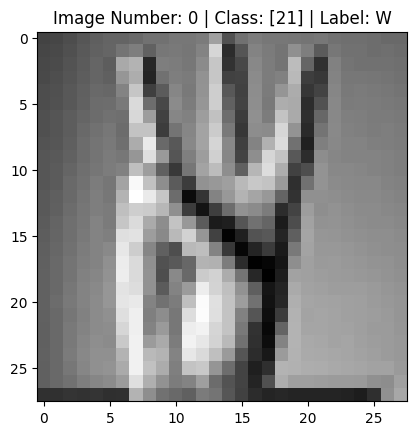

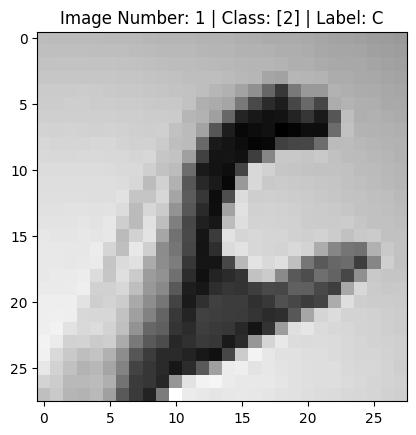

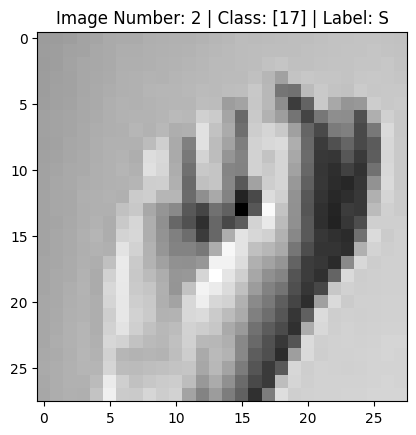

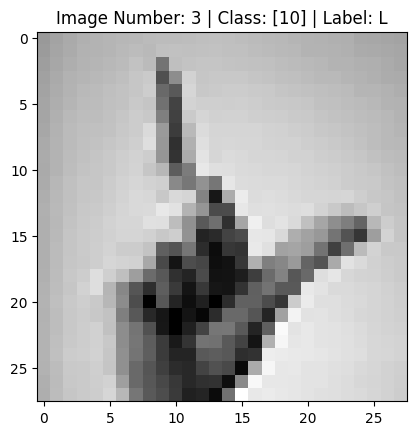

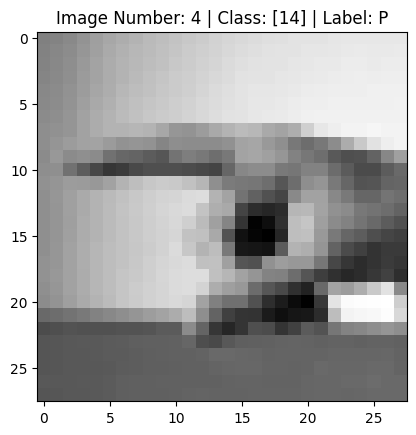

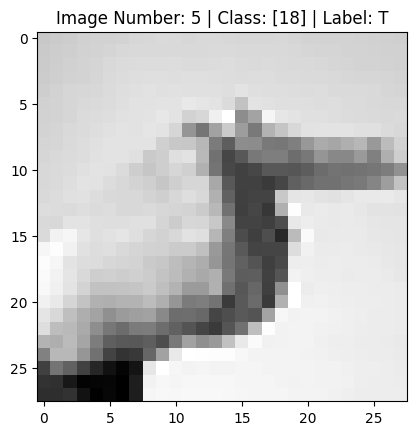

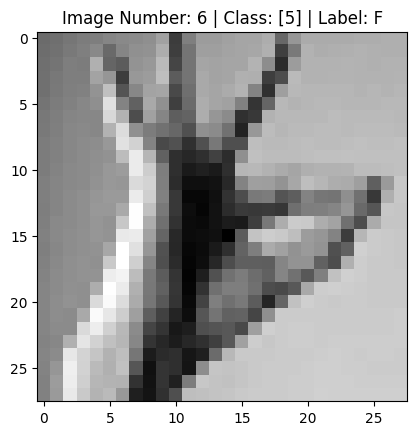

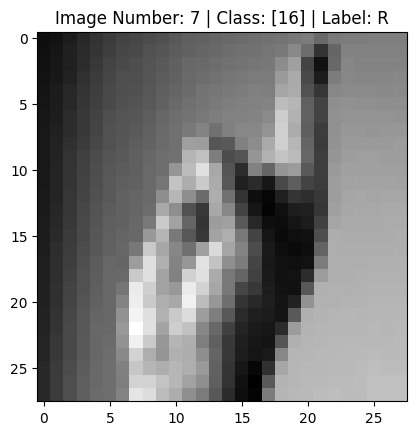

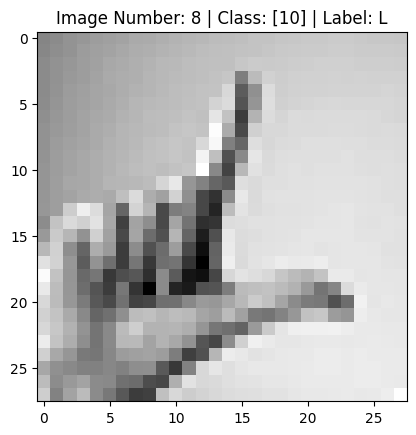

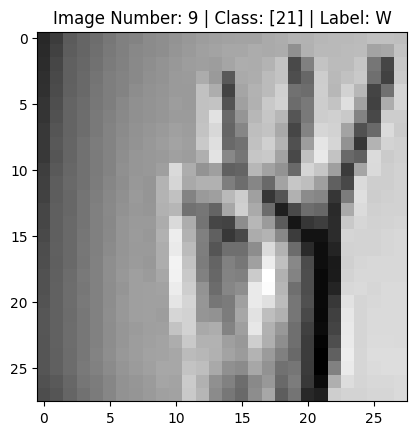

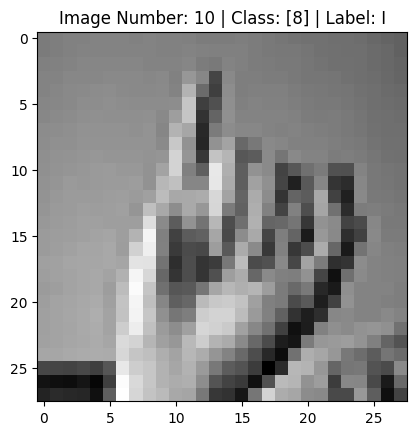

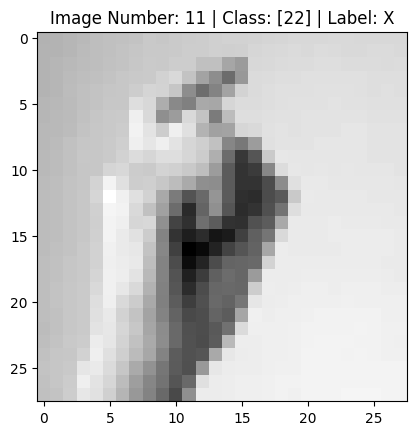

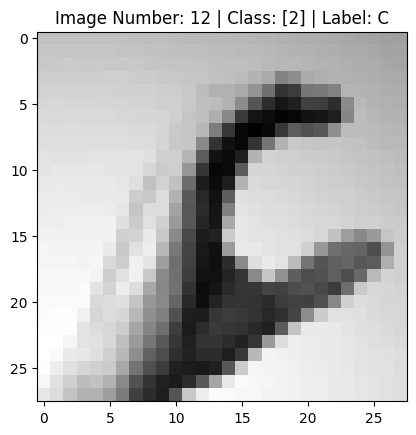

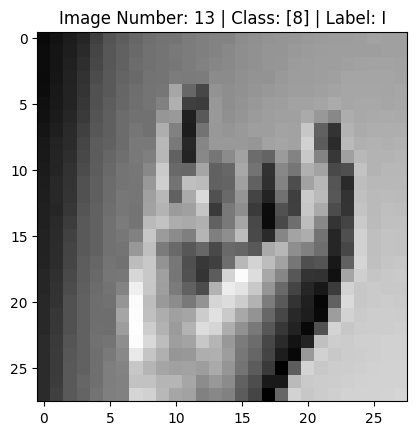

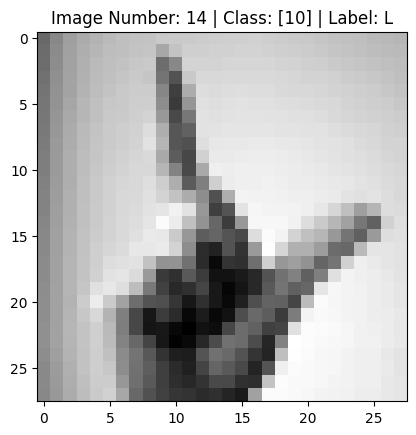

In [71]:
import matplotlib.pyplot as plt

for i in range(15):
    plt.imshow(x_train[i], cmap='gray')  #can add subplotting here later
    plt.title(f"Image Number: {i} | Class: {str(y_train[i])} | Label: {class_names[int(y_train[i])]}") #add 2 in image number to see that row in excel sheet data
    plt.show()

In [72]:
class_names[20]

'V'

In [73]:
len(class_names)

24

# 3g) Data Preparation (change categorical labels to OHE)

In [74]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_lb = label_binarizer.fit_transform(y_train)
y_val_lb = label_binarizer.fit_transform(y_val)
y_test_lb = label_binarizer.fit_transform(y_test)

In [75]:
y_train.shape

(19218, 1)

In [76]:
np.max(y_train)

23

In [77]:
np.min(y_train)

0

In [78]:
y_train_lb

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [79]:
print(x_train.shape)
print(y_train_lb.shape)
print(x_val.shape)
print(y_val_lb.shape)
print(x_test.shape)
print(y_test_lb.shape)

(19218, 28, 28, 1)
(19218, 24)
(8237, 28, 28, 1)
(8237, 24)
(7172, 28, 28, 1)
(7172, 24)


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, Activation, Flatten

In [81]:
model = Sequential()
model.add(Conv2D(filters =32, kernel_size= (3,3), strides = (1,1), padding= "valid"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters =32, kernel_size= (3,3), strides = (1,1), padding= "valid"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters =32, kernel_size= (2,2), strides = (1,1), padding= "valid"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(24, activation="softmax"))

In [82]:
model.compile(loss = "categorical_crossentropy", optimizer ="adam", metrics=["accuracy"])

In [83]:
y_test_lb.shape

(7172, 24)

In [84]:
y_test_lb

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [85]:
x_train

array([[[[0.51372549],
         [0.52156863],
         [0.5372549 ],
         ...,
         [0.61568627],
         [0.60784314],
         [0.60392157]],

        [[0.52156863],
         [0.52941176],
         [0.54509804],
         ...,
         [0.61568627],
         [0.61960784],
         [0.61176471]],

        [[0.5254902 ],
         [0.53333333],
         [0.55294118],
         ...,
         [0.62352941],
         [0.62352941],
         [0.61960784]],

        ...,

        [[0.58431373],
         [0.60392157],
         [0.63921569],
         ...,
         [0.74117647],
         [0.74117647],
         [0.72156863]],

        [[0.58431373],
         [0.60392157],
         [0.62745098],
         ...,
         [0.69803922],
         [0.69019608],
         [0.7372549 ]],

        [[0.47058824],
         [0.47058824],
         [0.47843137],
         ...,
         [0.46666667],
         [0.69803922],
         [0.75294118]]],


       [[[0.69019608],
         [0.68627451],
         [0.68

In [86]:
model.fit(x = x_train,
         y = y_train_lb,
         batch_size = 1000,
         validation_data = (x_val, y_val_lb),
         epochs = 30)

Epoch 1/30
20/20 [==============================] - 18s 827ms/step - loss: 3.1668 - accuracy: 0.0820 - val_loss: 3.1461 - val_accuracy: 0.1441
Epoch 2/30
20/20 [==============================] - 16s 793ms/step - loss: 3.1066 - accuracy: 0.1414 - val_loss: 3.0244 - val_accuracy: 0.1700
Epoch 3/30
20/20 [==============================] - 16s 795ms/step - loss: 2.8631 - accuracy: 0.2195 - val_loss: 2.6132 - val_accuracy: 0.2741
Epoch 4/30
20/20 [==============================] - 16s 779ms/step - loss: 2.3629 - accuracy: 0.3205 - val_loss: 2.1018 - val_accuracy: 0.3846
Epoch 5/30
20/20 [==============================] - 15s 732ms/step - loss: 1.9304 - accuracy: 0.4367 - val_loss: 1.7419 - val_accuracy: 0.4849
Epoch 6/30
20/20 [==============================] - 14s 708ms/step - loss: 1.6297 - accuracy: 0.5182 - val_loss: 1.5155 - val_accuracy: 0.5463
Epoch 7/30
20/20 [==============================] - 15s 726ms/step - loss: 1.4071 - accuracy: 0.5795 - val_loss: 1.3169 - val_accuracy: 0.6137

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 11, 11, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                   

## 3h) Plotting loss curve, accuracy curve

In [88]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
validation_accuracy = model.history.history['val_accuracy']

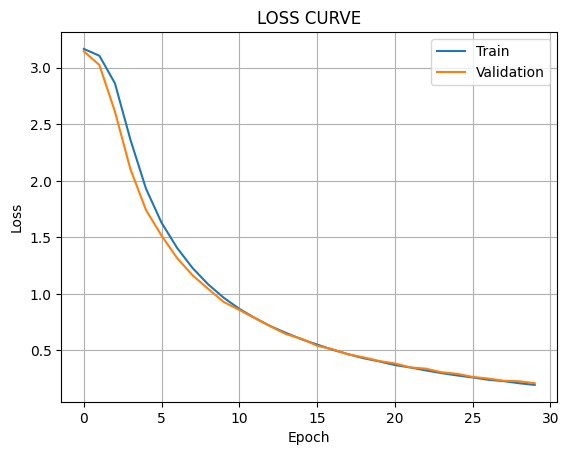

In [89]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS CURVE")
plt.legend((['Train', 'Validation']))
plt.grid()
plt.show()

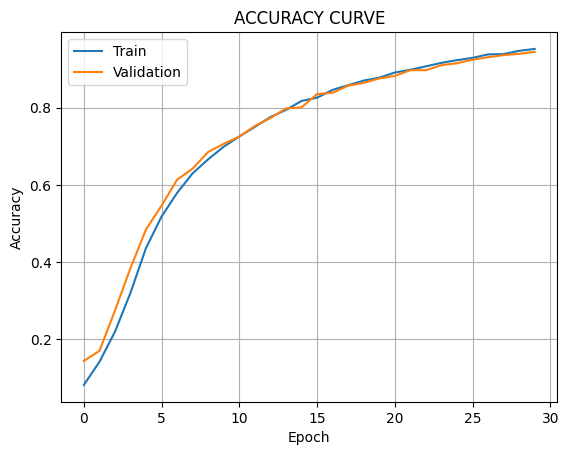

In [90]:
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ACCURACY CURVE")
plt.legend((['Train', 'Validation']))
plt.grid()
plt.show()

## 3i) Predicting


In [91]:
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
preds = model.predict(x_test)
preds_class = np.argmax(preds, axis =1)
preds.shape

225/225 [==============================] - 3s 11ms/step


(7172, 24)

In [93]:
y_test.shape

(7172, 1)

In [94]:
y_test

array([[6],
       [5],
       [9],
       ...,
       [2],
       [4],
       [2]])

In [95]:
y_test[1][0]

5

In [96]:
max(y_test)

array([23])

## 3j) Visualizing Predictions with ground truths

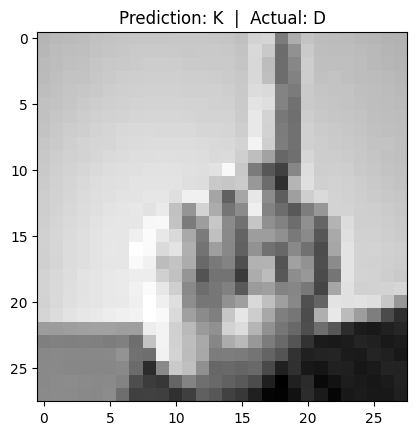

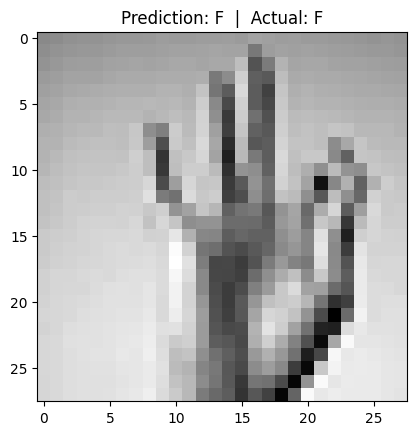

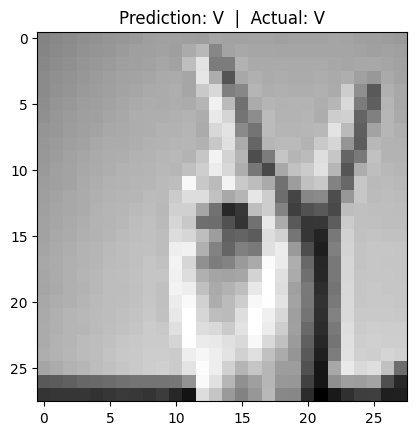

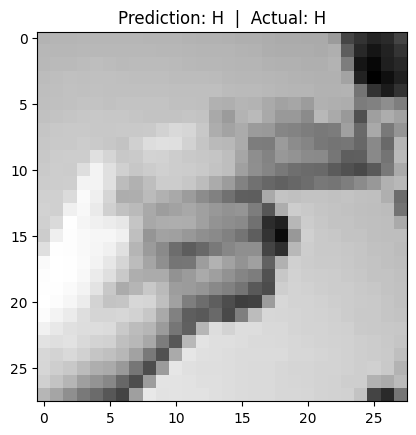

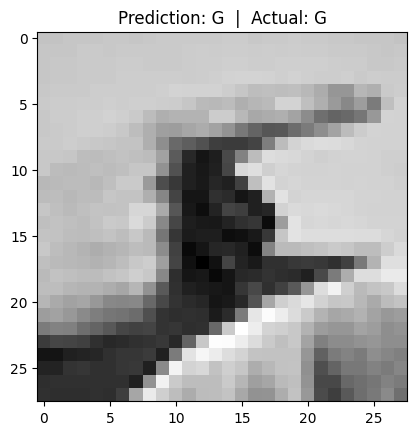

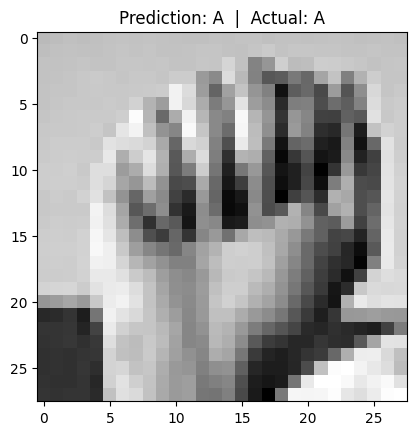

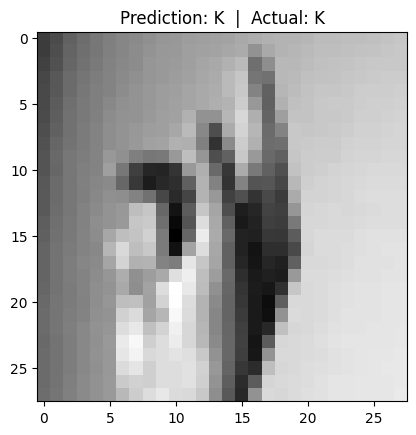

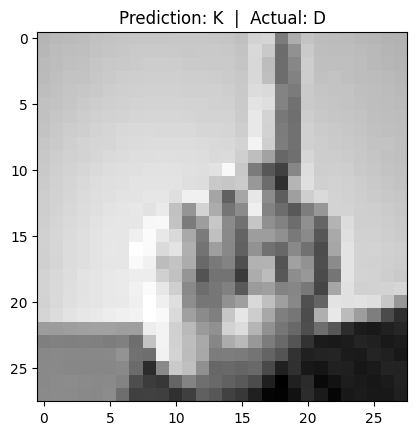

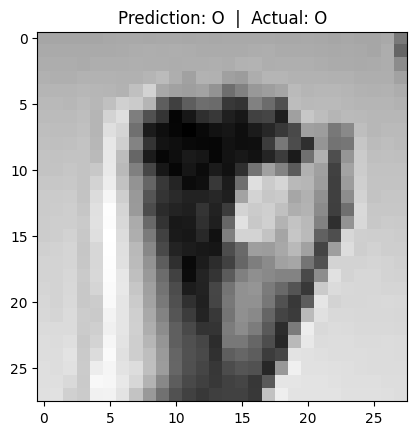

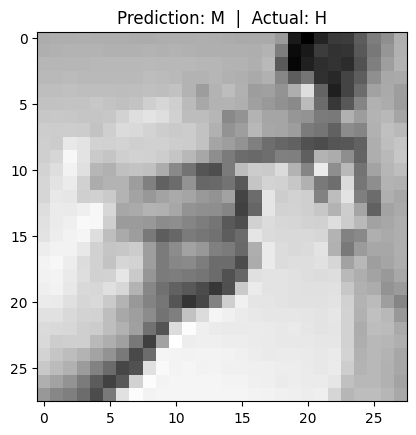

In [97]:
imgs = np.random.randint(0, 15, 10)

for n in imgs:
  plt.imshow(x_test[n].reshape(28,28), cmap="gray")
  plt.title(f"Prediction: {class_names[np.argmax(preds[n])]}  |  Actual: {class_names[y_test[n][0]]}")
  plt.show()

In [98]:
imgs

array([ 4,  1, 12,  9,  0,  3,  6,  4,  7, 14])

In [99]:
preds_class.shape

(7172,)

In [100]:
y_test

array([[6],
       [5],
       [9],
       ...,
       [2],
       [4],
       [2]])

## 3k) Performance metrics

In [101]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = preds_class)
print(pd.DataFrame(conf_matrix, columns = class_names, index = class_names))

     A    B    C    D    E    F    G    H    I    K  ...    P    Q   R    S  \
A  329    0    0    0    0    0    0    1    0    0  ...    0    0   0    1   
B    0  371    0    0    0    0    0    0    0    2  ...    1    0   0    0   
C    0    0  203    0    0    0    2    1    0    0  ...    0    0   0    0   
D   15    0    0  158    0   20    0    0    0   14  ...    0    0   0    0   
E    0    0    0    0  443    0    1    0    0    0  ...    0    0   0   49   
F    0    0    0    0    0  247    0    0    0    0  ...    0    0   0    0   
G    0    6    0    0    0    0  266   21    0    0  ...   17   10   0    0   
H    0    0    0    0    0    0   41  370    0    0  ...    5    0   0    0   
I    0    0    0    0    0    0    0    0  241    0  ...    0    3   0    0   
K    0    0    0    0    0    3    0    0    1  225  ...    0    1   0    0   
L    0    0   39    0    0    0    0    0    0    0  ...    0    0   0    0   
M    0    0    0    0   21    0    0    0    0    0 

In [102]:
print(classification_report(y_true = y_test, y_pred = preds_class))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       331
           1       0.97      0.86      0.91       432
           2       0.74      0.65      0.69       310
           3       0.84      0.64      0.73       245
           4       0.93      0.89      0.91       498
           5       0.77      1.00      0.87       247
           6       0.84      0.76      0.80       348
           7       0.90      0.85      0.88       436
           8       0.86      0.84      0.85       288
           9       0.79      0.68      0.73       331
          10       0.72      0.66      0.69       209
          11       0.87      0.77      0.82       394
          12       0.83      0.84      0.83       291
          13       0.65      0.72      0.69       246
          14       0.89      0.87      0.88       347
          15       0.86      0.96      0.90       164
          16       0.54      0.49      0.51       144
          17       0.58    

# 4)CNN model for Image Classification for the processed dataset with bigger training and test files

For training the CNN model, we used images from American Sign Language after processing them to find where the hand is detected to be and then reshaping the image into 100 X 100 pixels. We also created a test dataset from these ASL images to test the classifier.

Our training file is 7250 images (250 images for each of the 29 classes) and test file to 351 images which is around the same as what we did earlier for the 28X28 dataset for orignal MNIST in our 3rd model

# 4a) Import dataset

In [103]:
import pandas as pd
import numpy as np
train_data_df = pd.read_csv(r"/content/training3.csv", header = None)
test_data_df = pd.read_csv(r"/content/testing3.csv", header = None)

In [104]:
cols_in_data = ['label'] + [f'pixel{i}' for i in range(1,10001)]
train_data_df.columns = cols_in_data
test_data_df.columns = cols_in_data

In [105]:
train_data_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,0,30,30,29,30,30,29,29,30,29,...,85,85,85,84,84,84,84,83,82,55
1,0,30,31,29,30,30,29,29,29,28,...,86,85,84,84,85,84,83,83,82,55
2,0,31,30,29,30,30,30,29,30,30,...,87,87,87,87,86,86,86,85,83,56
3,0,29,31,28,30,29,29,29,28,29,...,93,94,95,96,96,98,99,101,101,64
4,0,29,30,30,29,28,29,29,30,29,...,94,94,96,95,97,98,98,100,100,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,28,31,29,30,29,29,28,29,29,29,...,60,59,57,54,52,51,50,50,51,41
7246,28,30,30,29,30,29,30,29,30,30,...,84,83,84,84,84,80,78,79,76,51
7247,28,29,31,29,30,29,30,30,29,29,...,84,83,84,83,80,77,75,69,66,45
7248,28,29,29,30,29,30,29,30,29,29,...,83,83,80,79,76,73,70,63,63,44


In [106]:
test_data_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,0,29,29,29,29,29,28,29,29,29,...,146,146,147,147,147,146,145,145,144,143
1,0,209,206,206,207,208,209,207,206,207,...,167,167,168,166,165,165,164,165,163,161
2,0,29,29,29,29,30,28,29,30,28,...,165,164,165,164,162,161,160,161,163,162
3,0,29,133,207,210,210,210,209,208,208,...,180,178,177,176,175,173,172,172,171,171
4,0,28,29,28,29,29,29,29,29,29,...,145,145,146,146,144,144,143,140,140,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,25,135,133,131,128,122,118,112,111,114,...,66,66,66,66,67,66,67,66,66,46
347,25,177,177,177,177,177,177,177,176,174,...,111,109,109,109,109,109,109,109,107,54
348,26,30,30,30,28,29,29,28,29,29,...,67,67,67,63,56,52,52,52,50,39
349,27,30,30,29,29,29,29,29,29,30,...,84,84,84,83,84,83,84,82,80,54


In [107]:
x_train_df = train_data_df.iloc[: , 1:]

In [108]:
x_train_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,30,30,29,30,30,29,29,30,29,30,...,85,85,85,84,84,84,84,83,82,55
1,30,31,29,30,30,29,29,29,28,29,...,86,85,84,84,85,84,83,83,82,55
2,31,30,29,30,30,30,29,30,30,29,...,87,87,87,87,86,86,86,85,83,56
3,29,31,28,30,29,29,29,28,29,29,...,93,94,95,96,96,98,99,101,101,64
4,29,30,30,29,28,29,29,30,29,29,...,94,94,96,95,97,98,98,100,100,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,31,29,30,29,29,28,29,29,29,30,...,60,59,57,54,52,51,50,50,51,41
7246,30,30,29,30,29,30,29,30,30,30,...,84,83,84,84,84,80,78,79,76,51
7247,29,31,29,30,29,30,30,29,29,29,...,84,83,84,83,80,77,75,69,66,45
7248,29,29,30,29,30,29,30,29,29,29,...,83,83,80,79,76,73,70,63,63,44


In [109]:
y_train_df = train_data_df.iloc[: , :1]

In [110]:
y_train_df

,label
0,0
1,0
2,0
3,0
4,0
...,...
7245,28
7246,28
7247,28
7248,28


In [111]:
max(y_train_df['label'])

28

In [112]:
min(y_train_df['label'])

0

In [113]:
x_test_df = test_data_df.iloc[: , 1:]


In [114]:
x_test_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,29,29,29,29,29,28,29,29,29,29,...,146,146,147,147,147,146,145,145,144,143
1,209,206,206,207,208,209,207,206,207,207,...,167,167,168,166,165,165,164,165,163,161
2,29,29,29,29,30,28,29,30,28,29,...,165,164,165,164,162,161,160,161,163,162
3,29,133,207,210,210,210,209,208,208,208,...,180,178,177,176,175,173,172,172,171,171
4,28,29,28,29,29,29,29,29,29,29,...,145,145,146,146,144,144,143,140,140,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,135,133,131,128,122,118,112,111,114,113,...,66,66,66,66,67,66,67,66,66,46
347,177,177,177,177,177,177,177,176,174,174,...,111,109,109,109,109,109,109,109,107,54
348,30,30,30,28,29,29,28,29,29,29,...,67,67,67,63,56,52,52,52,50,39
349,30,30,29,29,29,29,29,29,30,29,...,84,84,84,83,84,83,84,82,80,54


In [115]:
y_test_df = test_data_df.iloc[: , :1]

In [116]:
y_test_df

,label
0,0
1,0
2,0
3,0
4,0
...,...
346,25
347,25
348,26
349,27


In [117]:
print(x_train_df.shape)
print(y_train_df.shape)
print(x_test_df.shape)
print(y_test_df.shape)

(7250, 10000)
(7250, 1)
(351, 10000)
(351, 1)


## **4b) Normalize the data (greyscale normalization for faster convergence)**




In [118]:
x_train_df = x_train_df/255
x_test_df = x_test_df/255



In [119]:
x_train_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,0.117647,0.117647,0.113725,0.117647,0.117647,0.113725,0.113725,0.117647,0.113725,0.117647,...,0.333333,0.333333,0.333333,0.329412,0.329412,0.329412,0.329412,0.325490,0.321569,0.215686
1,0.117647,0.121569,0.113725,0.117647,0.117647,0.113725,0.113725,0.113725,0.109804,0.113725,...,0.337255,0.333333,0.329412,0.329412,0.333333,0.329412,0.325490,0.325490,0.321569,0.215686
2,0.121569,0.117647,0.113725,0.117647,0.117647,0.117647,0.113725,0.117647,0.117647,0.113725,...,0.341176,0.341176,0.341176,0.341176,0.337255,0.337255,0.337255,0.333333,0.325490,0.219608
3,0.113725,0.121569,0.109804,0.117647,0.113725,0.113725,0.113725,0.109804,0.113725,0.113725,...,0.364706,0.368627,0.372549,0.376471,0.376471,0.384314,0.388235,0.396078,0.396078,0.250980
4,0.113725,0.117647,0.117647,0.113725,0.109804,0.113725,0.113725,0.117647,0.113725,0.113725,...,0.368627,0.368627,0.376471,0.372549,0.380392,0.384314,0.384314,0.392157,0.392157,0.250980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,0.121569,0.113725,0.117647,0.113725,0.113725,0.109804,0.113725,0.113725,0.113725,0.117647,...,0.235294,0.231373,0.223529,0.211765,0.203922,0.200000,0.196078,0.196078,0.200000,0.160784
7246,0.117647,0.117647,0.113725,0.117647,0.113725,0.117647,0.113725,0.117647,0.117647,0.117647,...,0.329412,0.325490,0.329412,0.329412,0.329412,0.313725,0.305882,0.309804,0.298039,0.200000
7247,0.113725,0.121569,0.113725,0.117647,0.113725,0.117647,0.117647,0.113725,0.113725,0.113725,...,0.329412,0.325490,0.329412,0.325490,0.313725,0.301961,0.294118,0.270588,0.258824,0.176471
7248,0.113725,0.113725,0.117647,0.113725,0.117647,0.113725,0.117647,0.113725,0.113725,0.113725,...,0.325490,0.325490,0.313725,0.309804,0.298039,0.286275,0.274510,0.247059,0.247059,0.172549


In [120]:
x_test_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,pixel10000
0,0.113725,0.113725,0.113725,0.113725,0.113725,0.109804,0.113725,0.113725,0.113725,0.113725,...,0.572549,0.572549,0.576471,0.576471,0.576471,0.572549,0.568627,0.568627,0.564706,0.560784
1,0.819608,0.807843,0.807843,0.811765,0.815686,0.819608,0.811765,0.807843,0.811765,0.811765,...,0.654902,0.654902,0.658824,0.650980,0.647059,0.647059,0.643137,0.647059,0.639216,0.631373
2,0.113725,0.113725,0.113725,0.113725,0.117647,0.109804,0.113725,0.117647,0.109804,0.113725,...,0.647059,0.643137,0.647059,0.643137,0.635294,0.631373,0.627451,0.631373,0.639216,0.635294
3,0.113725,0.521569,0.811765,0.823529,0.823529,0.823529,0.819608,0.815686,0.815686,0.815686,...,0.705882,0.698039,0.694118,0.690196,0.686275,0.678431,0.674510,0.674510,0.670588,0.670588
4,0.109804,0.113725,0.109804,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,...,0.568627,0.568627,0.572549,0.572549,0.564706,0.564706,0.560784,0.549020,0.549020,0.549020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.529412,0.521569,0.513725,0.501961,0.478431,0.462745,0.439216,0.435294,0.447059,0.443137,...,0.258824,0.258824,0.258824,0.258824,0.262745,0.258824,0.262745,0.258824,0.258824,0.180392
347,0.694118,0.694118,0.694118,0.694118,0.694118,0.694118,0.694118,0.690196,0.682353,0.682353,...,0.435294,0.427451,0.427451,0.427451,0.427451,0.427451,0.427451,0.427451,0.419608,0.211765
348,0.117647,0.117647,0.117647,0.109804,0.113725,0.113725,0.109804,0.113725,0.113725,0.113725,...,0.262745,0.262745,0.262745,0.247059,0.219608,0.203922,0.203922,0.203922,0.196078,0.152941
349,0.117647,0.117647,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.117647,0.113725,...,0.329412,0.329412,0.329412,0.325490,0.329412,0.325490,0.329412,0.321569,0.313725,0.211765


In [121]:
y_train_df

,label
0,0
1,0
2,0
3,0
4,0
...,...
7245,28
7246,28
7247,28
7248,28


In [122]:
y_test_df

,label
0,0
1,0
2,0
3,0
4,0
...,...
346,25
347,25
348,26
349,27


## 4c) Making validation data

In [123]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_df, y_train_df, test_size = 0.3, random_state = 42)

In [124]:
#dataframe to numpy
x_train = x_train.values
y_train = y_train.values
x_val = x_val.values
y_val = y_val.values
x_test = x_test_df.values
y_test = y_test_df.values

In [125]:
y_train

array([[ 3],
       [ 9],
       [ 6],
       ...,
       [20],
       [21],
       [ 3]])

## 4d) Reshaping the data from 1-D to 3-D as required through input by CNN's


In [126]:
x_train = x_train.reshape(-1,100,100,1)
x_val = x_val.reshape(-1,100,100,1)
x_test = x_test.reshape(-1,100,100,1)

In [127]:
x_train.shape

(5075, 100, 100, 1)

In [128]:
x_train.shape[0]

5075

In [129]:
x_train[0].shape

(100, 100, 1)

In [130]:
x_train[0]

array([[[0.12156863],
        [0.11372549],
        [0.11764706],
        ...,
        [0.11764706],
        [0.10980392],
        [0.11764706]],

       [[0.11764706],
        [0.45490196],
        [0.45098039],
        ...,
        [0.30588235],
        [0.42352941],
        [0.25882353]],

       [[0.11372549],
        [0.39215686],
        [0.39607843],
        ...,
        [0.42745098],
        [0.41960784],
        [0.2627451 ]],

       ...,

       [[0.11764706],
        [0.85882353],
        [0.8627451 ],
        ...,
        [0.65882353],
        [0.67058824],
        [0.39607843]],

       [[0.11764706],
        [0.85490196],
        [0.85490196],
        ...,
        [0.67058824],
        [0.67058824],
        [0.39607843]],

       [[0.11764706],
        [0.4745098 ],
        [0.47843137],
        ...,
        [0.38823529],
        [0.38823529],
        [0.24705882]]])

In [131]:
y_train.shape

(5075, 1)

In [132]:
y_test.shape

(351, 1)

## 4e) Declare classes in our classification

In [133]:
class_names = ['A','B','C','D','E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Del', 'N', 'Space']

In [134]:
class_names[28]

'Space'

In [135]:
len(class_names)

29

In [136]:
y_train

array([[ 3],
       [ 9],
       [ 6],
       ...,
       [20],
       [21],
       [ 3]])

In [137]:
class_names[int(y_train[1])]

'J'

In [138]:
int(y_train[1])

9

# 4f) Visualize few images

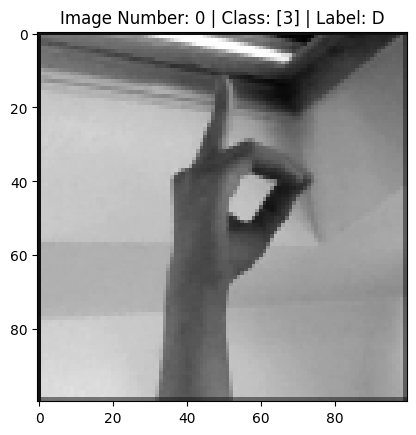

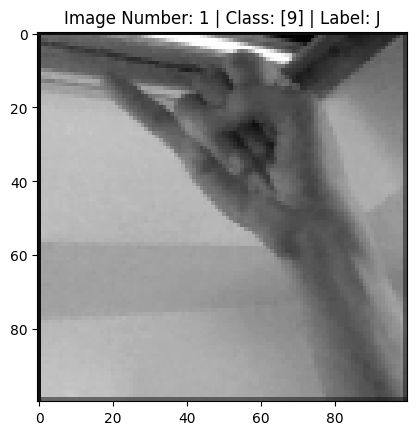

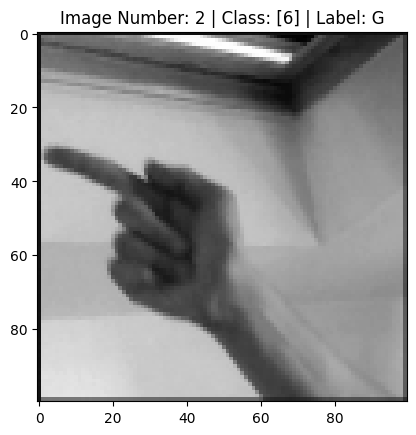

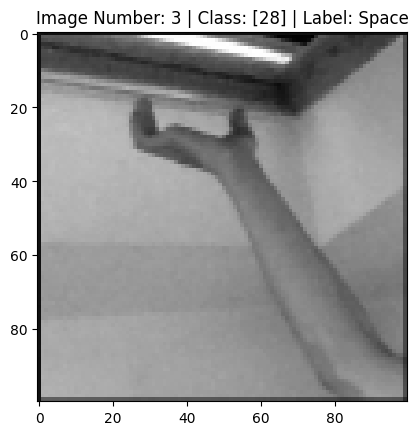

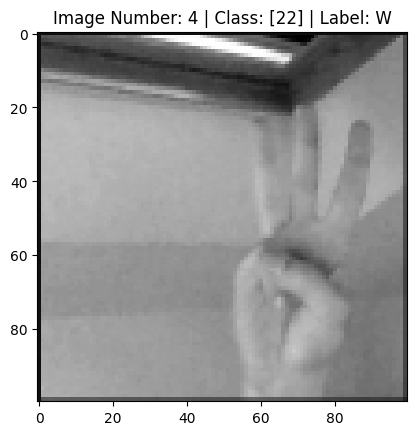

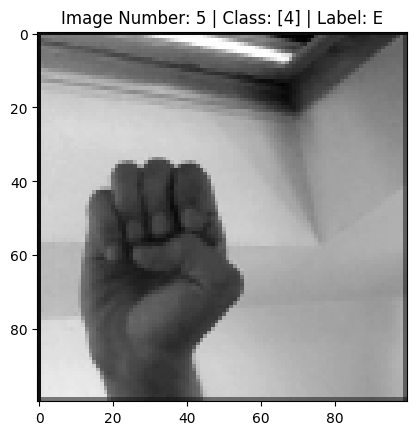

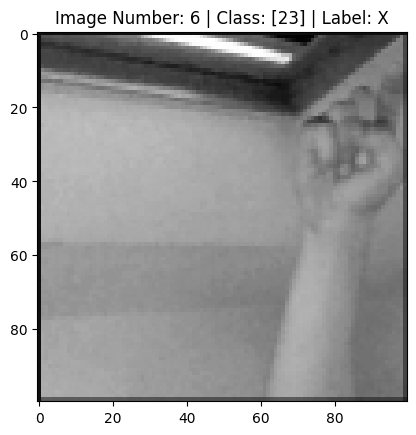

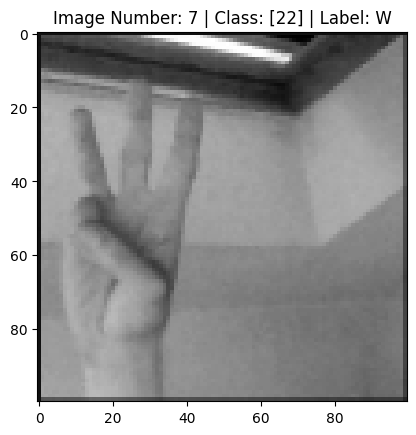

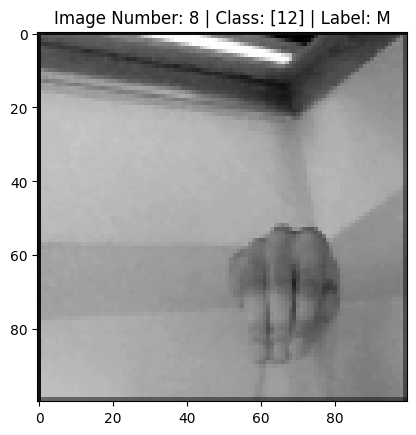

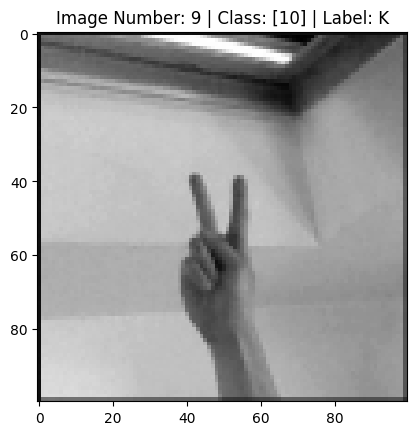

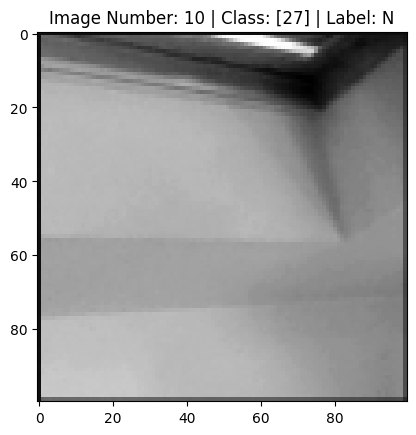

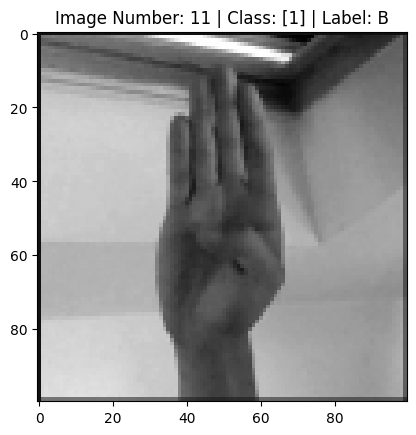

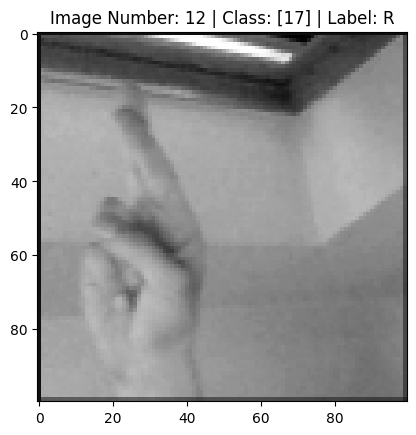

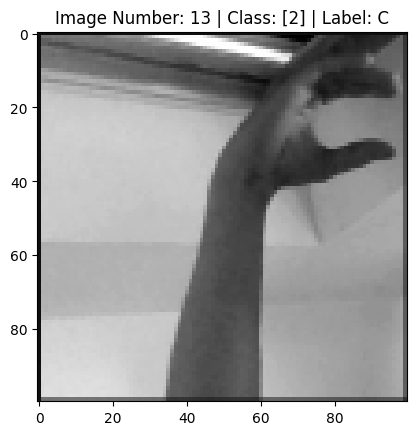

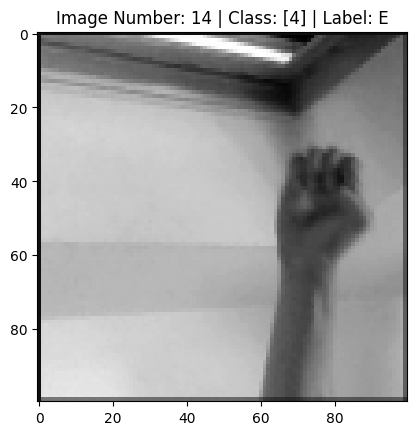

In [139]:
import matplotlib.pyplot as plt

for i in range(15):
    plt.imshow(x_train[i], cmap='gray')  #can add subplotting here later
    plt.title(f"Image Number: {i} | Class: {str(y_train[i])} | Label: {class_names[int(y_train[i])]}")
    plt.show()

In [140]:
class_names[20]

'U'

In [141]:
len(class_names)

29

# 4g) Data Preparation (change categorical labels to OHE)

In [142]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_lb = label_binarizer.fit_transform(y_train)
y_val_lb = label_binarizer.fit_transform(y_val)
y_test_lb = label_binarizer.fit_transform(y_test)

In [143]:
y_train.shape

(5075, 1)

In [144]:
np.max(y_train)

28

In [145]:
np.min(y_train)

0

In [146]:
y_train_lb

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [147]:
print(x_train.shape)
print(y_train_lb.shape)
print(x_val.shape)
print(y_val_lb.shape)
print(x_test.shape)
print(y_test_lb.shape)

(5075, 100, 100, 1)
(5075, 29)
(2175, 100, 100, 1)
(2175, 29)
(351, 100, 100, 1)
(351, 29)


##4h) Model Building

In [148]:
from tensorflow.keras.models import Sequential

In [149]:
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [150]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size= (3,3), strides = (1,1), padding= "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size= (3,3), strides = (1,1), padding= "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size= (3,3), strides = (1,1), padding= "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Dropout(rate=0.3))
model.add(Dense(29, activation="softmax"))

In [151]:
optimizer = Adam(learning_rate=0.0000000001, weight_decay=1e-2)
model.compile(loss = "categorical_crossentropy", optimizer ="adam", metrics=["accuracy"])

In [152]:
y_test_lb.shape

(351, 29)

In [153]:
y_test_lb

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [154]:
x_train

array([[[[0.12156863],
         [0.11372549],
         [0.11764706],
         ...,
         [0.11764706],
         [0.10980392],
         [0.11764706]],

        [[0.11764706],
         [0.45490196],
         [0.45098039],
         ...,
         [0.30588235],
         [0.42352941],
         [0.25882353]],

        [[0.11372549],
         [0.39215686],
         [0.39607843],
         ...,
         [0.42745098],
         [0.41960784],
         [0.2627451 ]],

        ...,

        [[0.11764706],
         [0.85882353],
         [0.8627451 ],
         ...,
         [0.65882353],
         [0.67058824],
         [0.39607843]],

        [[0.11764706],
         [0.85490196],
         [0.85490196],
         ...,
         [0.67058824],
         [0.67058824],
         [0.39607843]],

        [[0.11764706],
         [0.4745098 ],
         [0.47843137],
         ...,
         [0.38823529],
         [0.38823529],
         [0.24705882]]],


       [[[0.11764706],
         [0.11372549],
         [0.11

In [155]:
print(x_train.shape)
print(y_train_lb.shape)
print(x_val.shape)
print(y_val_lb.shape)

(5075, 100, 100, 1)
(5075, 29)
(2175, 100, 100, 1)
(2175, 29)


In [156]:
model.fit(x = x_train,
         y = y_train_lb,
         batch_size = 8,
         validation_data = (x_val, y_val_lb),
         epochs = 30)

Epoch 1/30
635/635 [==============================] - 106s 165ms/step - loss: 3.2603 - accuracy: 0.6410 - val_loss: 0.5306 - val_accuracy: 0.8589
Epoch 2/30
635/635 [==============================] - 107s 169ms/step - loss: 0.2801 - accuracy: 0.9263 - val_loss: 0.5129 - val_accuracy: 0.8487
Epoch 3/30
635/635 [==============================] - 109s 172ms/step - loss: 0.1142 - accuracy: 0.9718 - val_loss: 0.4745 - val_accuracy: 0.8589
Epoch 4/30
635/635 [==============================] - 106s 168ms/step - loss: 0.0913 - accuracy: 0.9766 - val_loss: 0.1496 - val_accuracy: 0.9646
Epoch 5/30
635/635 [==============================] - 107s 168ms/step - loss: 0.0829 - accuracy: 0.9815 - val_loss: 0.1348 - val_accuracy: 0.9761
Epoch 6/30
635/635 [==============================] - 104s 164ms/step - loss: 0.0893 - accuracy: 0.9762 - val_loss: 0.5735 - val_accuracy: 0.8464
Epoch 7/30
635/635 [==============================] - 108s 170ms/step - loss: 0.0440 - accuracy: 0.9898 - val_loss: 0.1923 -

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 16)      64        
 Normalization)                                                  
                                                                 
 activation_3 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)       

## 4i) Plotting loss curve, accuracy curve

In [158]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
validation_accuracy = model.history.history['val_accuracy']

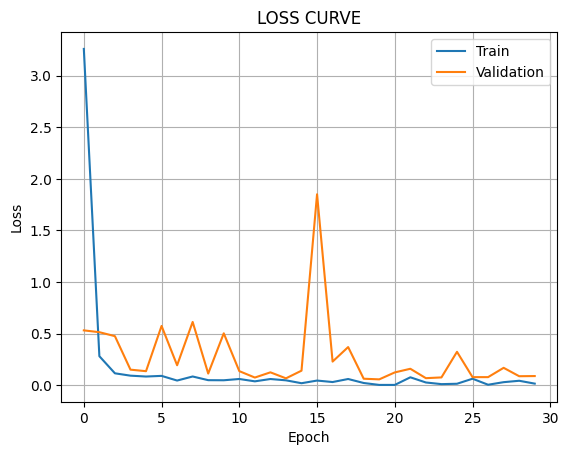

In [159]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS CURVE")
plt.legend((['Train', 'Validation']))
plt.grid()
plt.show()

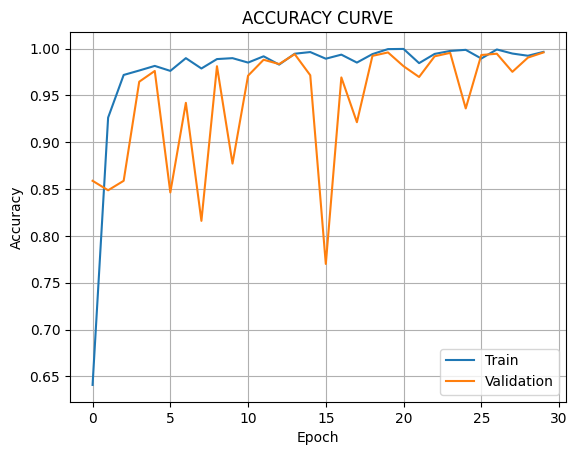

In [160]:
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ACCURACY CURVE")
plt.legend((['Train', 'Validation']))
plt.grid()
plt.show()

## 4j) Predicting


In [161]:
from sklearn.metrics import classification_report, confusion_matrix

In [162]:
preds = model.predict(x_test)
preds_class = np.argmax(preds, axis =1)
preds.shape

11/11 [==============================] - 1s 105ms/step


(351, 29)

In [163]:
y_test.shape

(351, 1)

In [164]:
y_test

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 5],
       [ 5],
       [ 5],
       [ 5],
       [ 5],

In [165]:
y_test[1][0]

0

In [166]:
max(y_test)

array([28])

## 4k) Visualizing Predictions with ground Truths

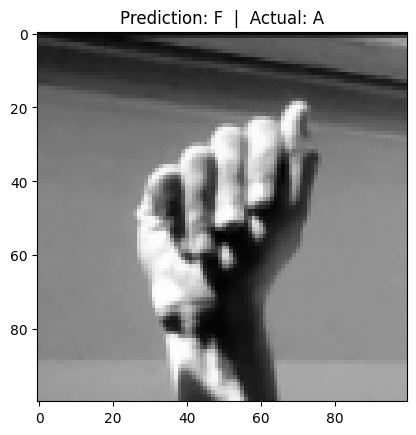

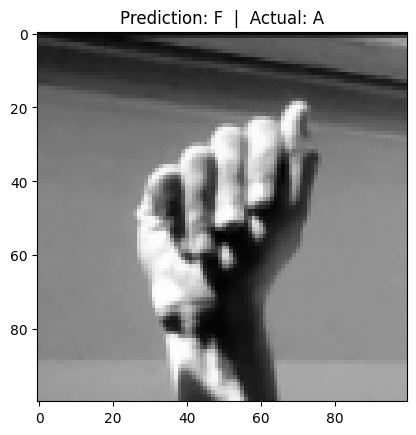

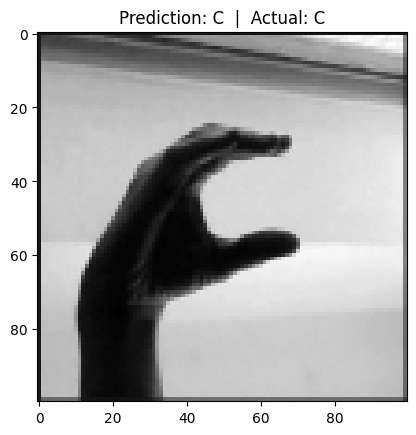

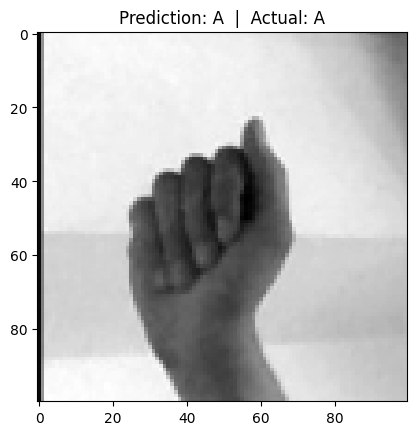

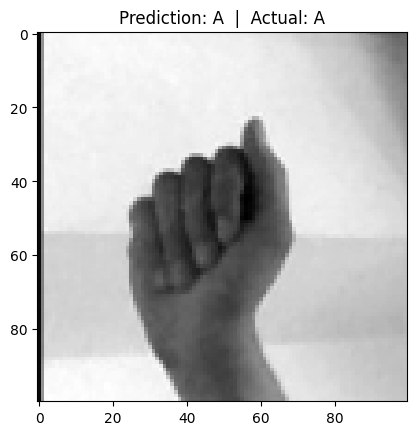

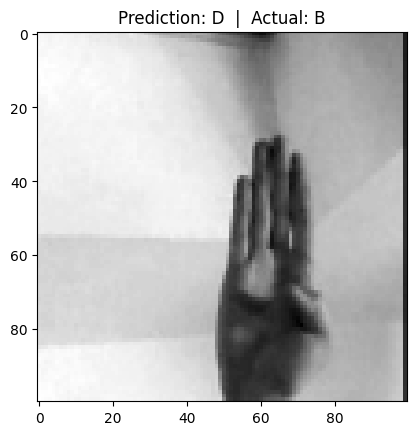

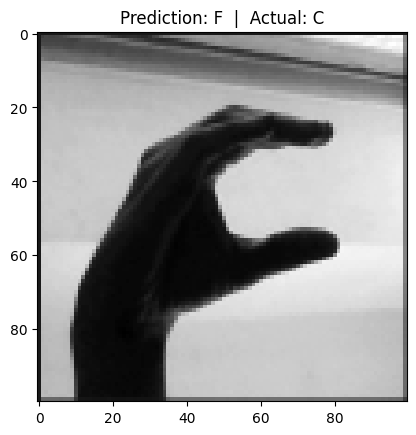

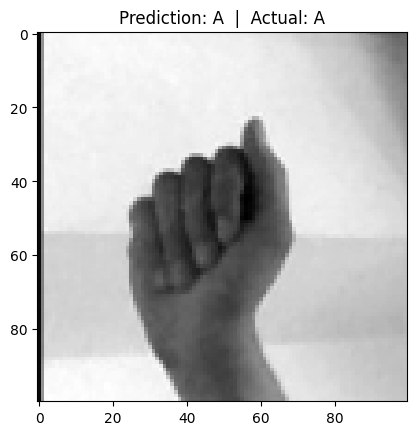

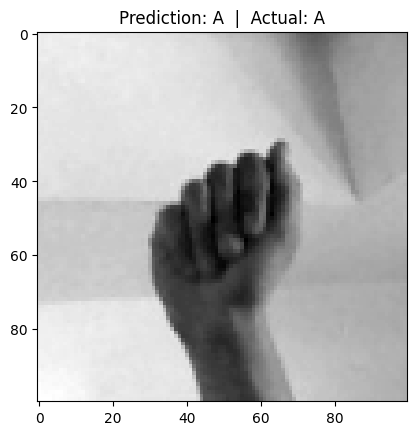

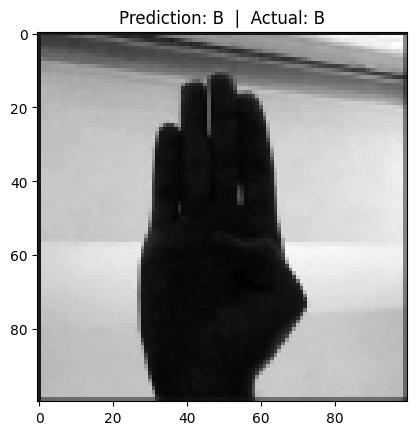

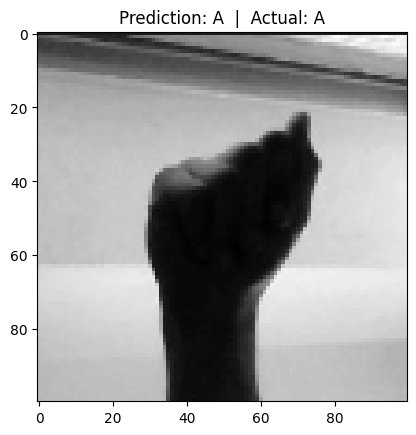

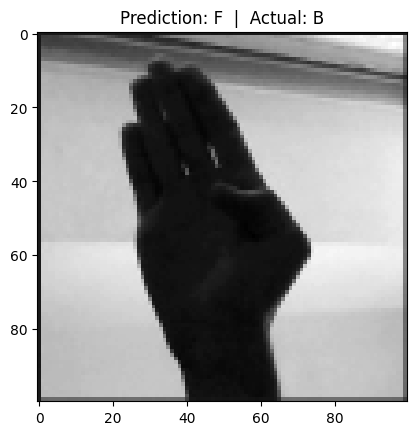

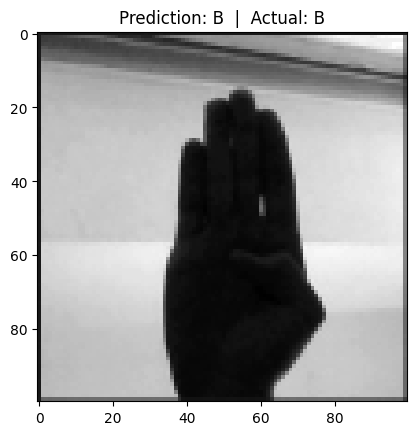

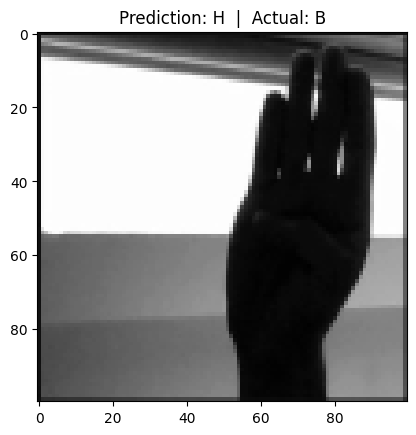

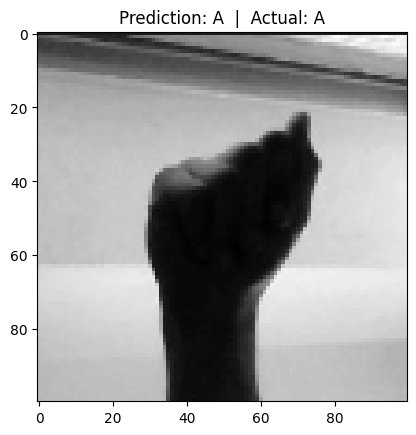

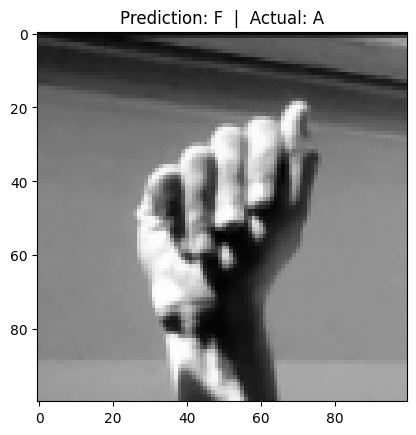

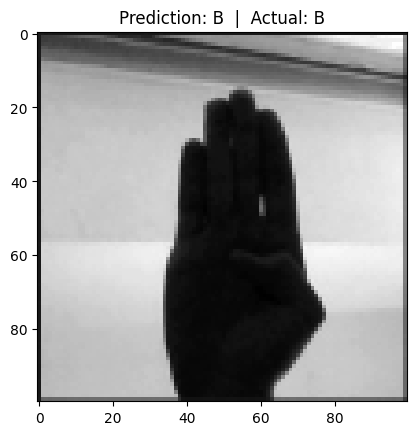

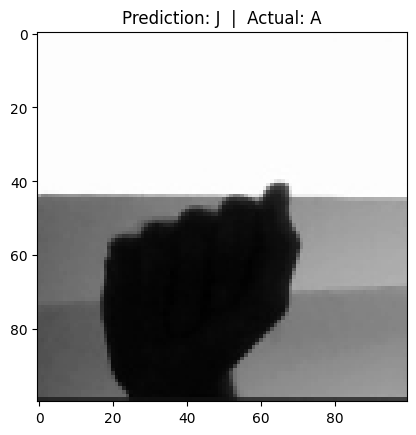

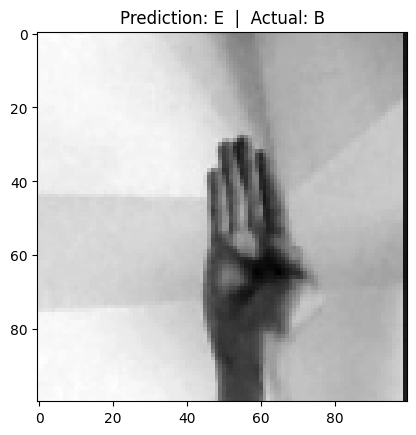

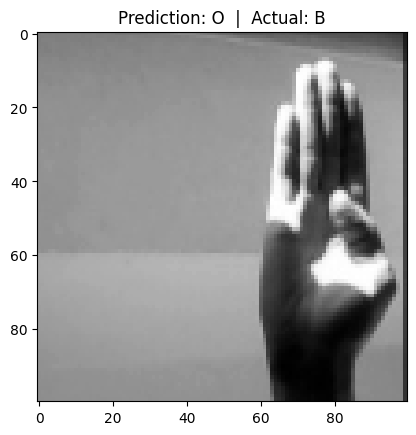

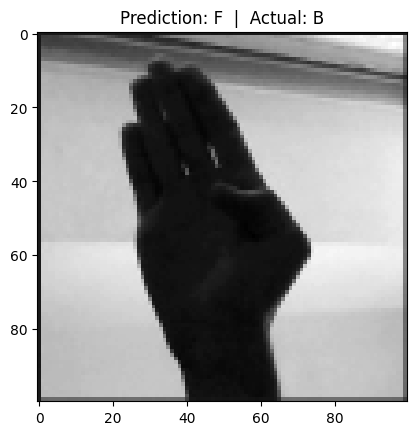

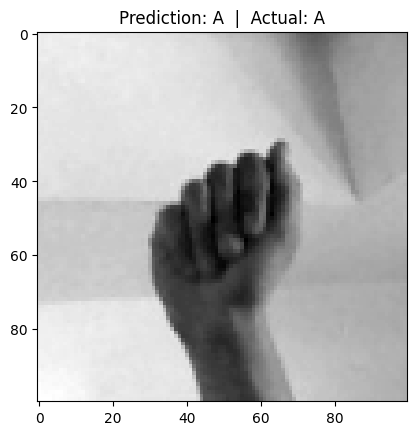

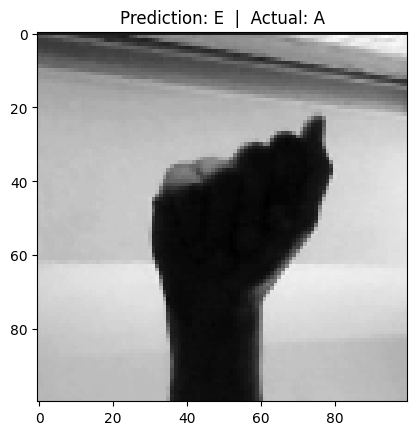

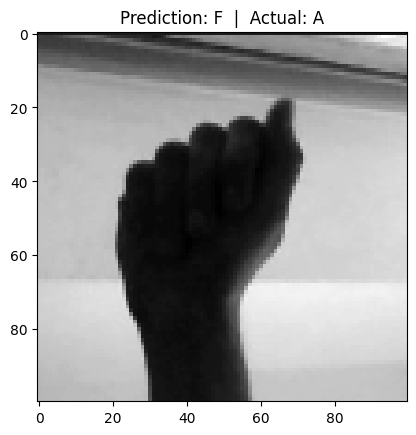

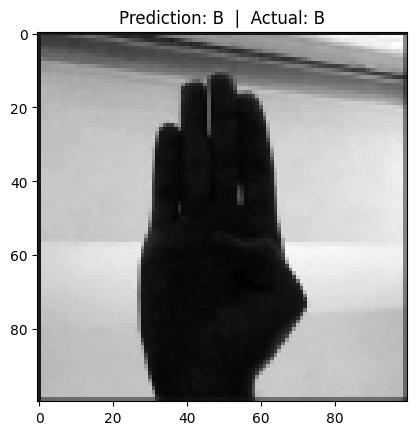

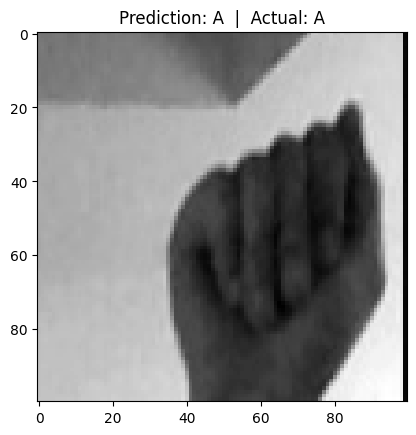

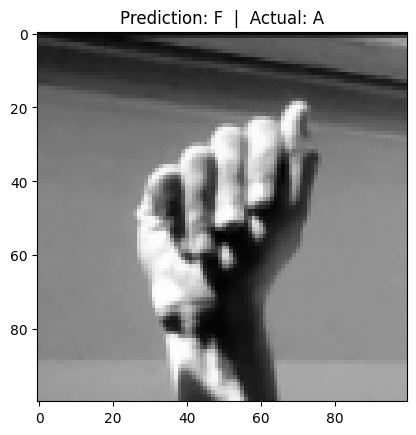

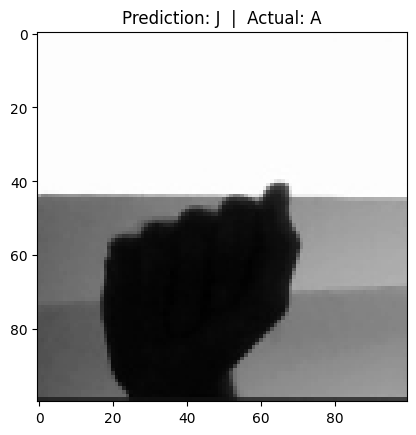

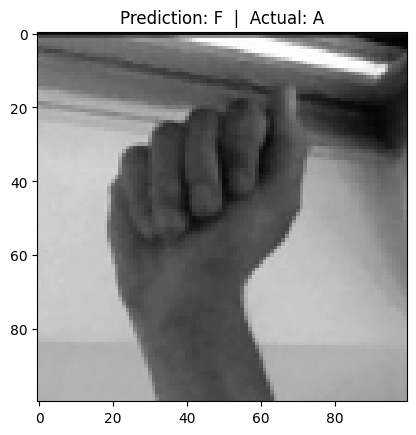

In [167]:
imgs = np.random.randint(0,29, 29)

for n in imgs:
  plt.imshow(x_test[n].reshape(100,100), cmap="gray")
  plt.title(f"Prediction: {class_names[np.argmax(preds[n])]}  |  Actual: {class_names[y_test[n][0]]}")
  plt.show()

In [168]:
imgs

array([10, 10, 28,  3,  3, 15, 24,  3,  1, 20,  4, 23, 16, 19,  4, 10, 16,
        7, 14, 21, 23,  1,  8, 11, 20,  6, 10,  7,  2])

In [169]:
preds_class.shape

(351,)

In [170]:
y_test

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 5],
       [ 5],
       [ 5],
       [ 5],
       [ 5],

## 4l) Performance metrics

In [171]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = preds_class)
print(pd.DataFrame(conf_matrix, columns = class_names, index = class_names))

       A  B  C  D  E  F  G  H  I  J  ...  T  U  V  W  X  Y  Z  Del   N  Space
A      6  0  0  0  1  3  0  0  0  1  ...  0  0  0  0  0  0  0    0   1      0
B      0  4  0  2  1  1  0  1  0  0  ...  0  0  0  0  0  0  0    0   2      0
C      0  0  7  1  0  1  0  0  0  0  ...  0  0  0  0  0  0  0    0   1      0
D      0  0  1  5  0  1  0  0  0  0  ...  1  0  0  1  0  1  0    0   0      0
E      0  2  0  1  4  1  0  1  1  0  ...  0  0  0  0  0  0  0    0   1      0
F      0  0  0  0  0  7  1  0  0  0  ...  0  0  0  0  0  0  1    0   0      0
G      1  0  0  0  0  0  8  1  0  0  ...  0  0  0  2  0  0  0    0   0      0
H      0  0  0  0  0  0  3  7  0  1  ...  0  0  0  0  0  0  0    0   0      0
I      0  0  0  0  0  1  0  1  4  0  ...  1  0  0  1  0  0  0    1   0      0
J      0  0  0  0  0  1  1  4  0  3  ...  1  0  0  0  0  1  0    0   0      1
K      0  0  0  0  0  1  0  0  0  0  ...  0  0  0  2  0  0  0    0   0      0
L      0  0  1  0  0  0  0  0  0  0  ...  0  0  0  1  0  0  1   

In [172]:
print(classification_report(y_true = y_test, y_pred = preds_class))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.50      0.33      0.40        12
           2       0.58      0.58      0.58        12
           3       0.42      0.42      0.42        12
           4       0.29      0.33      0.31        12
           5       0.28      0.58      0.38        12
           6       0.47      0.67      0.55        12
           7       0.32      0.58      0.41        12
           8       0.57      0.33      0.42        12
           9       0.30      0.25      0.27        12
          10       0.39      0.75      0.51        12
          11       0.75      0.50      0.60        12
          12       0.29      0.33      0.31        12
          13       1.00      0.42      0.59        12
          14       0.16      0.25      0.19        12
          15       0.50      0.25      0.33        12
          16       0.50      0.58      0.54        12
          17       0.67    

## 4m) Saving model for reuse for prediction for the project

In [173]:
model.save_weights('my_model_weights.h5') #saving model weights

In [174]:
model.save('my_model.h5') #saving model weight and architecture

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [175]:
#saving only architecture
model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)